In [199]:
import torch
import torch.nn.functional as F
from torchvision import transforms as tf
from datetime import datetime

In [115]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [76]:
img = Image.open('chess.jpg').convert('RGB')

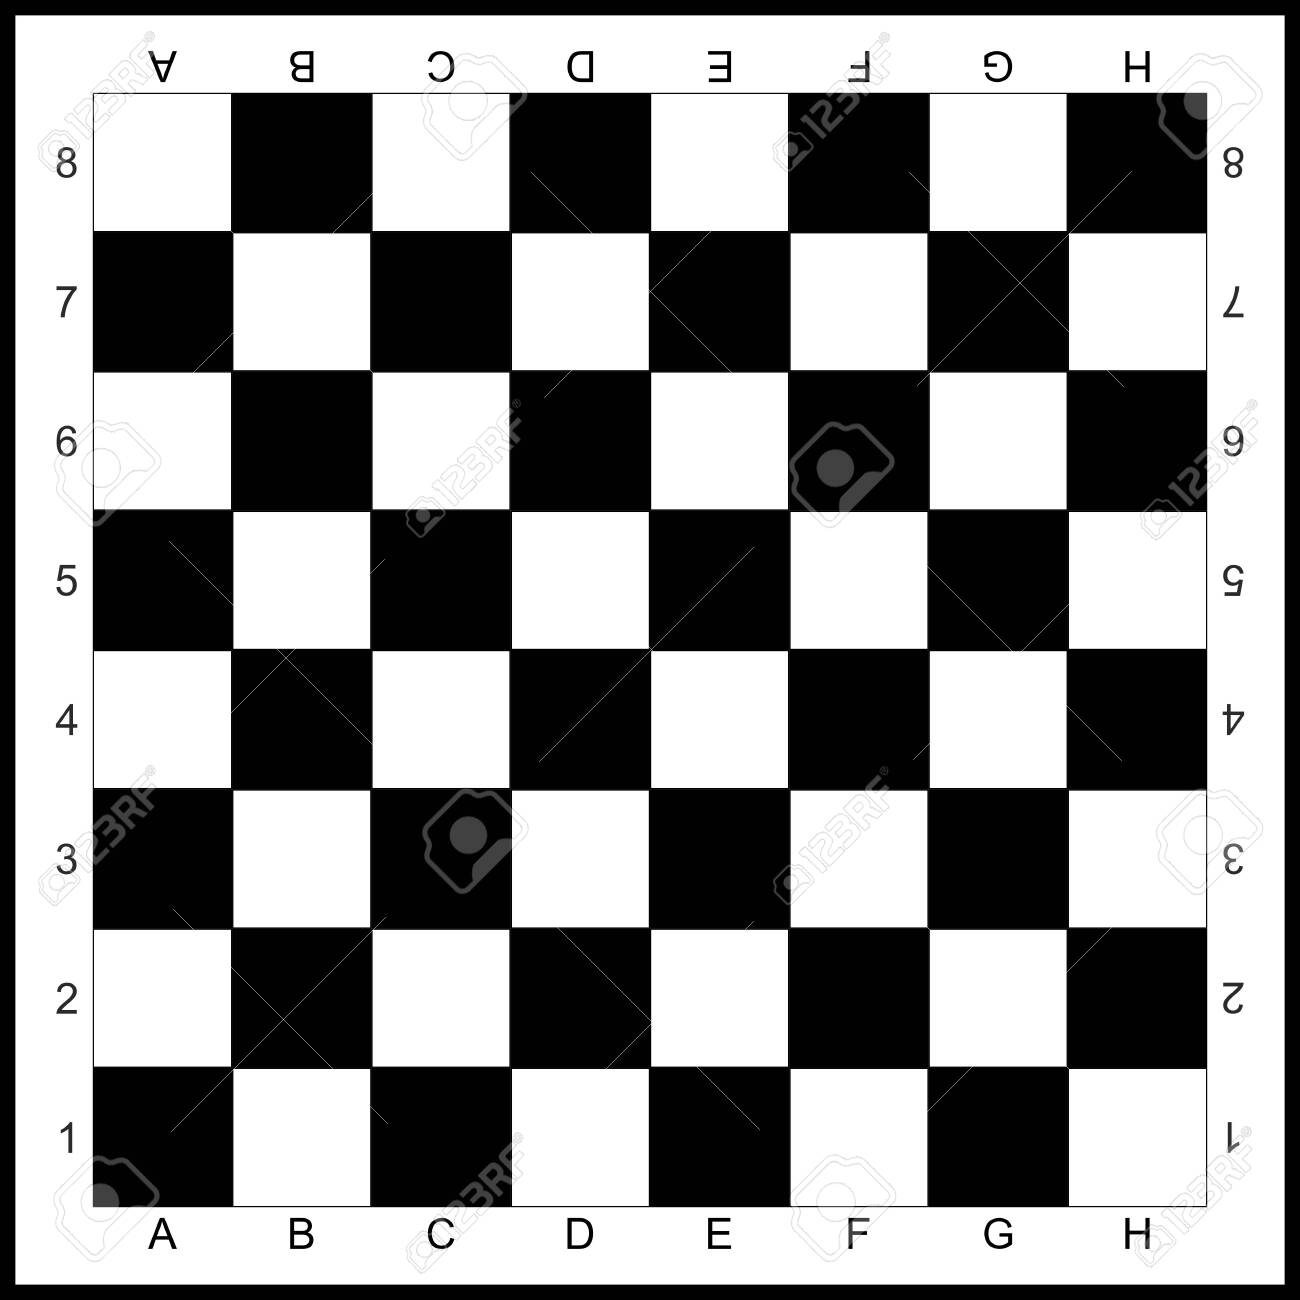

In [77]:
img

In [78]:
transforms = tf.Compose([
    tf.Resize(265),
    tf.ToTensor()
])

In [79]:
img_tensor = transforms(img)

In [80]:
img_tensor.shape

torch.Size([3, 265, 265])

In [81]:
img_tensor = img_tensor.unsqueeze(0) # adding batch 

In [82]:
img_tensor.shape

torch.Size([1, 3, 265, 265])

In [83]:
sharpen_kernel = [[
    [[0, -1, 0]], 
    [[-1, 5, -1]],
    [[0, -1, 0]]
]]
horizontal_kernel = [[
    [[5, 0, -5]], 
    [[0, 0, 0]],
    [[-5, 0, 5]]
]]
vertical_kernel = [[
    [[0, 1, 0]], 
    [[1, -4, 1]],
    [[0, 1, 0]]
]]
edge_kernel = [[
    [[-1, -1, -1]], 
    [[-1, 8, -1]],
    [[-1, -1, -1]]
]]

In [84]:
def get_conv_output(img_tensor, kernel):
    conv_filter = torch.tensor(kernel, dtype = torch.float)
    print(conv_filter.shape)          # ( #channels of feature map, 
                                      #    channels of input img, 
                                      #    height of kernel, 
                                      #    width of kernel)
    
    conv_img = F.conv2d(img_tensor, conv_filter, padding = 0)
    print(conv_img.shape)
    
    conv_img = conv_img[0, :, :, :]   # Removing the batch size dimension
    print(conv_img.shape)
    
    conv_img = conv_img.numpy().squeeze()
    print(conv_img.shape)
    plt.imshow(conv_img, cmap='gray')

torch.Size([1, 3, 1, 3])
torch.Size([1, 1, 265, 263])
torch.Size([1, 265, 263])
(265, 263)


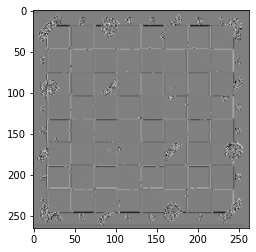

In [86]:
get_conv_output(img_tensor, horizontal_kernel)

torch.Size([1, 3, 1, 3])
torch.Size([1, 1, 265, 263])
torch.Size([1, 265, 263])
(265, 263)


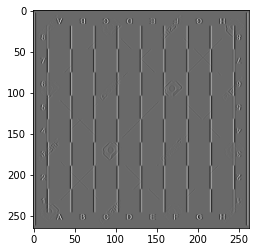

In [87]:
get_conv_output(img_tensor, vertical_kernel)

torch.Size([1, 3, 1, 3])
torch.Size([1, 1, 265, 263])
torch.Size([1, 265, 263])
(265, 263)


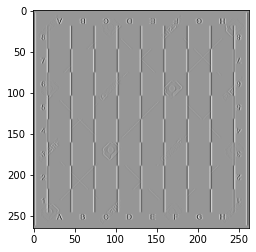

In [88]:
get_conv_output(img_tensor, edge_kernel)

In [176]:
from torchvision import models
from torch import optim

In [90]:
vgg = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/shubham/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100.0%


In [94]:
for param in vgg.parameters():
    param.requires_grad_(False)

In [96]:
vgg.to('cpu')

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [107]:
mean = (0.485, 0.465, 0.406)
std = (0.229, 0.224, 0.224)

In [122]:
def transformations(img):
    tasks = tf.Compose([
        tf.Resize(256), 
        tf.ToTensor(), 
        tf.Normalize(mean,std)
    ])
    img = tasks(img)
    img = img.unsqueeze(0)
    return img

def tensor_to_img(tensor):
    img = tensor.clone().detach()
    img = img.cpu().numpy().squeeze()
    img = img.transpose(1,2,0)
    img *=np.array(std) + np.mean(mean)
    
    img = img.clip(0,1)
    return img

In [229]:
content_img = Image.open('cat.jpg').convert('RGB')
style_img = Image.open('starry.jpg').convert('RGB')

In [230]:
content_img = transformations(content_img).to('cpu')
style_img = transformations(style_img).to('cpu')

In [231]:
content_img.shape

torch.Size([1, 3, 256, 455])

In [232]:
style_img.shape

torch.Size([1, 3, 256, 321])

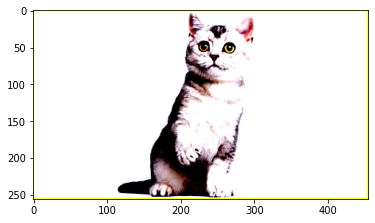

In [233]:
plt.imshow(tensor_to_img(content_img))

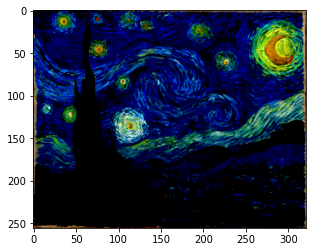

In [234]:
plt.imshow(tensor_to_img(style_img))

In [235]:
LAYERS_OF_INTEREST = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10' : 'conv3_1',
    '19' : 'conv4_1',
    '21' : 'conv4_2',
    '28' : 'conv5_1'
}

In [236]:
def apply_model_and_extract_features(image, model):
    features = {}
    x = image

    for name, layer in vgg._modules.items():
        x = layer(x)
        
        if name in LAYERS_OF_INTEREST:
            features[LAYERS_OF_INTEREST[name]] = x
    return features

In [237]:
content_img_features = apply_model_and_extract_features(content_img, vgg)
style_img_features = apply_model_and_extract_features(style_img, vgg)

In [238]:

def calculate_gram_matrix(tensor):
    _, channels, width, height = tensor.size()
    tensor = tensor.view(channels, height*width)
    
    gram_matrix = torch.mm(tensor, tensor.t())
    gram_matrix = gram_matrix.div(channels*width*height)
    return gram_matrix

In [239]:
calculate_gram_matrix(style_img)

tensor([[0.3824, 0.2049, 0.0302],
        [0.2049, 0.1622, 0.0805],
        [0.0302, 0.0805, 0.1209]])

In [240]:
style_features_gram_matrix = {layer: calculate_gram_matrix(style_img_features[layer]) for layer in style_img_features}

In [241]:
weights = dict(zip(LAYERS_OF_INTEREST.values(), [1.0, 0.75, 0.35, 0.25, 0.15]))
print(weights)

{'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.35, 'conv4_1': 0.25, 'conv4_2': 0.15}


In [242]:
target = content_img.clone().requires_grad_(True).to('cpu')

In [243]:
optimizer = optim.Adam([target], lr = 0.003)

In [ ]:
for i in range(1, 500):
    start_time = datetime.now()
    target_features = apply_model_and_extract_features(target, vgg)
    content_loss = F.mse_loss(target_features['conv4_2'], content_img_features['conv4_2'])
    
    style_loss = 0
    for layer in weights:
        target_feature = target_features[layer]
        
        target_gram_matrix = calculate_gram_matrix(target_feature)
        style_gram_matrix = style_features_gram_matrix[layer]
        
        layer_loss = F.mse_loss(target_gram_matrix, style_gram_matrix)
        layer_loss = layer_loss*weights[layer]
        
        style_loss = style_loss+ layer_loss
        
    total_loss = 1000000*style_loss + content_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    if i%10 == 0:
        print("Epoch {}: ContentLoss: {:4f} StyleLoss: {:4f} TotalLoss: {:4f} time/epoch: {}".format(i, 
                                                                                                     content_loss, 
                                                                                                     style_loss, 
                                                                                                     total_loss,
                                                                                                    datetime.now()-start_time))

Epoch 10: ContentLoss: 1.416834 StyleLoss: 0.000064 TotalLoss: 65.481049 time/epoch: 0:00:02.310266
Epoch 20: ContentLoss: 2.187756 StyleLoss: 0.000052 TotalLoss: 54.433964 time/epoch: 0:00:02.531980
Epoch 30: ContentLoss: 2.664886 StyleLoss: 0.000045 TotalLoss: 47.846661 time/epoch: 0:00:02.213795
Epoch 40: ContentLoss: 2.963806 StyleLoss: 0.000040 TotalLoss: 43.339592 time/epoch: 0:00:02.865590
Epoch 50: ContentLoss: 3.140587 StyleLoss: 0.000037 TotalLoss: 39.831024 time/epoch: 0:00:02.107570
Epoch 60: ContentLoss: 3.251231 StyleLoss: 0.000034 TotalLoss: 37.071415 time/epoch: 0:00:02.038293
Epoch 70: ContentLoss: 3.323296 StyleLoss: 0.000032 TotalLoss: 34.828453 time/epoch: 0:00:02.045590
Epoch 80: ContentLoss: 3.360887 StyleLoss: 0.000030 TotalLoss: 32.962513 time/epoch: 0:00:02.497670
Epoch 90: ContentLoss: 3.374779 StyleLoss: 0.000028 TotalLoss: 31.372047 time/epoch: 0:00:03.147614
Epoch 100: ContentLoss: 3.373842 StyleLoss: 0.000027 TotalLoss: 29.993259 time/epoch: 0:00:03.304866

In [ ]:
plt.figure(figsize = (30,15))
plt.subplot(1,2,1)
plt.imshow(tensor_to_img(content_img))
plt.subplot(1,2,2)
plt.imshow(tensor_to_img(target))